In [1]:
import nest
import numpy as np
import pandas as pd
import sys
import os

import time
import datetime

from tinydb import TinyDB, Query

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import statsmodels.api as sm

%matplotlib notebook

/home/brian/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
root_dir = os.path.join(os.path.expanduser("~"), 'nest_logger')
db = TinyDB(os.path.join(root_dir, 'db.json'))

df = pd.DataFrame(db.all())
df.last_connection = pd.to_datetime(df.last_connection)
df.request_time = pd.to_datetime(df.request_time)

df['cooling'] = df.hvac_state == 'cooling'  

# Temp differentials
df['setpoint_delta'] = df.temperature - df.target
df['setpoint_delta'][df.setpoint_delta < 0] = 0
df['setpoint_delta'][df.cooling == 0] = 0

df['ext_delta'] = df.ext_temperature - df.target
df['ext_delta'][df.ext_delta < 0] = 0
df['ext_delta'][df.cooling == 0] = 0

/home/brian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/brian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/brian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/brian/anaconda3/lib/python3.6/site-packages/ipykernel_

<IPython.core.display.Javascript object>


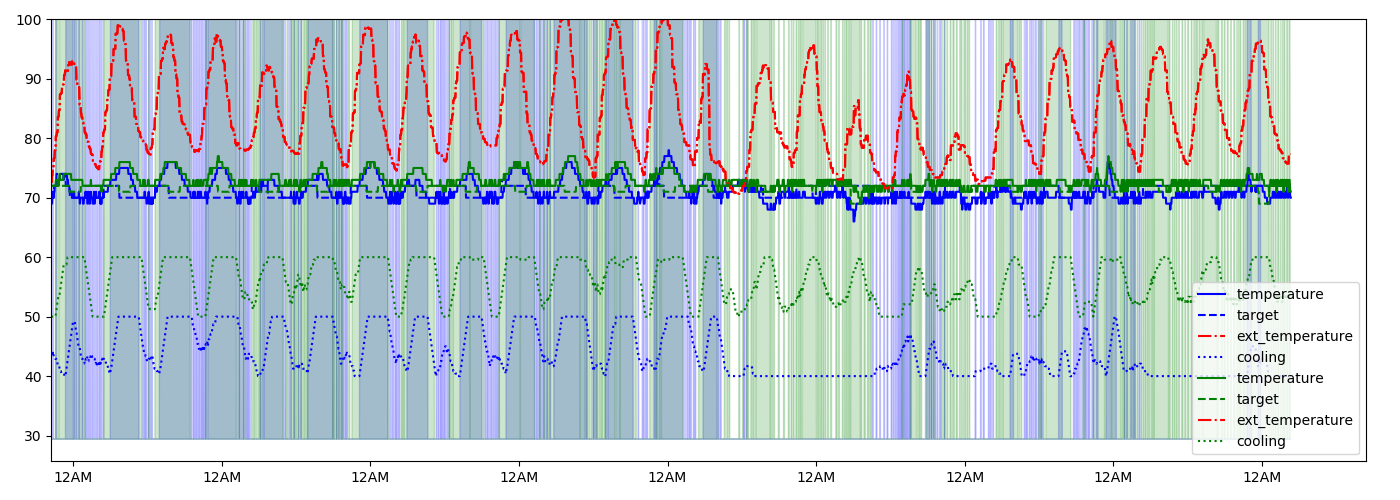

In [14]:
min_temp = min(df.temperature.min(), df.ext_temperature.min(), df.target.min())
max_temp = max(df.temperature.max(), df.ext_temperature.max(), df.target.max()) 


plt.figure(figsize=[14,5])

ax = plt.gca()

for  n, name, ls, c in zip([0,1], ['Upstairs', 'Downstairs'], ['-','-.'], ['b', 'g']):

    pdf = df[df.name == name]
    plt.plot(pdf.request_time, pdf.temperature, '-', c=c)
    plt.plot(pdf.request_time, pdf.target, '--', c=c)
    plt.plot(pdf.request_time, pdf.ext_temperature, '-.', c='r')
    plt.plot(pdf.request_time, pdf.cooling.rolling(24).mean()*10+40+10*n, ':', c=c)
    
    times = pdf.request_time.astype(datetime.datetime).as_matrix()
    
    plt.fill_between(times, np.ones(pdf.shape[0])*min_temp, pdf.cooling*(max_temp-min_temp) + min_temp, alpha=0.2, color=c)


    myFmt = mdates.DateFormatter('%-I%p')
    ax.xaxis.set_major_formatter(myFmt)

    plt.legend()
    plt.grid()
    plt.tight_layout()

<IPython.core.display.Javascript object>


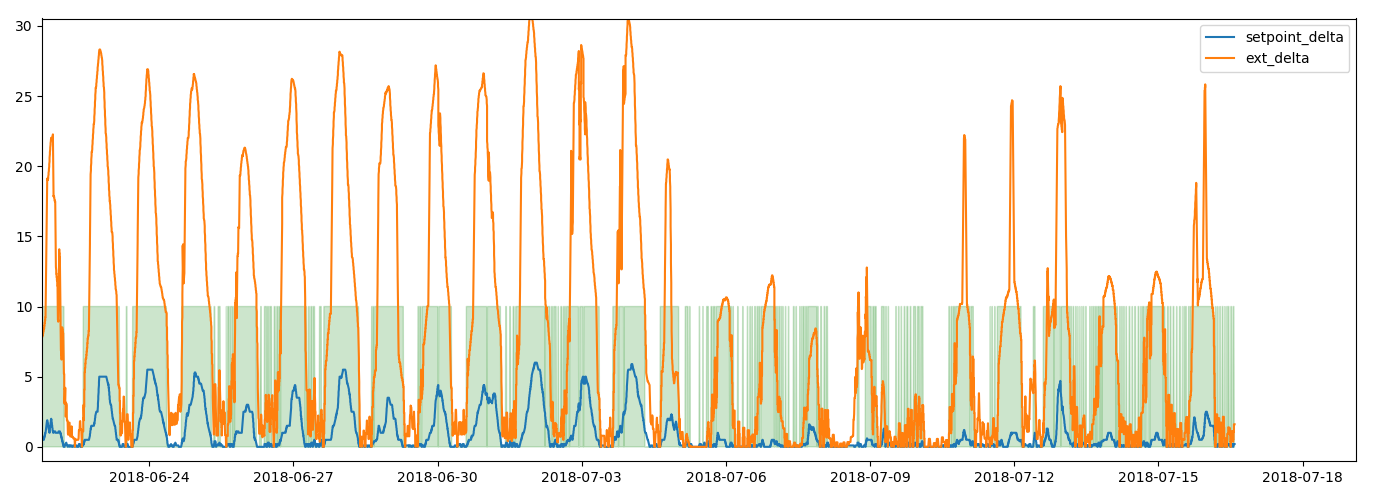

In [4]:
plt.figure(figsize=[14,5])

plt.plot(df.request_time, df.setpoint_delta.rolling(10).mean())
plt.plot(df.request_time, df.ext_delta.rolling(10).mean())

plt.fill_between(times, np.ones(pdf.shape[0])*0, pdf.cooling*10, alpha=0.2, color=c)

plt.legend()
plt.tight_layout()

In [5]:
pre_repair = df[df.request_time < datetime.date(year=2018, month=7, day=5)]
post_repair = df[df.request_time >= datetime.date(year=2018, month=7, day=5)]

<IPython.core.display.Javascript object>


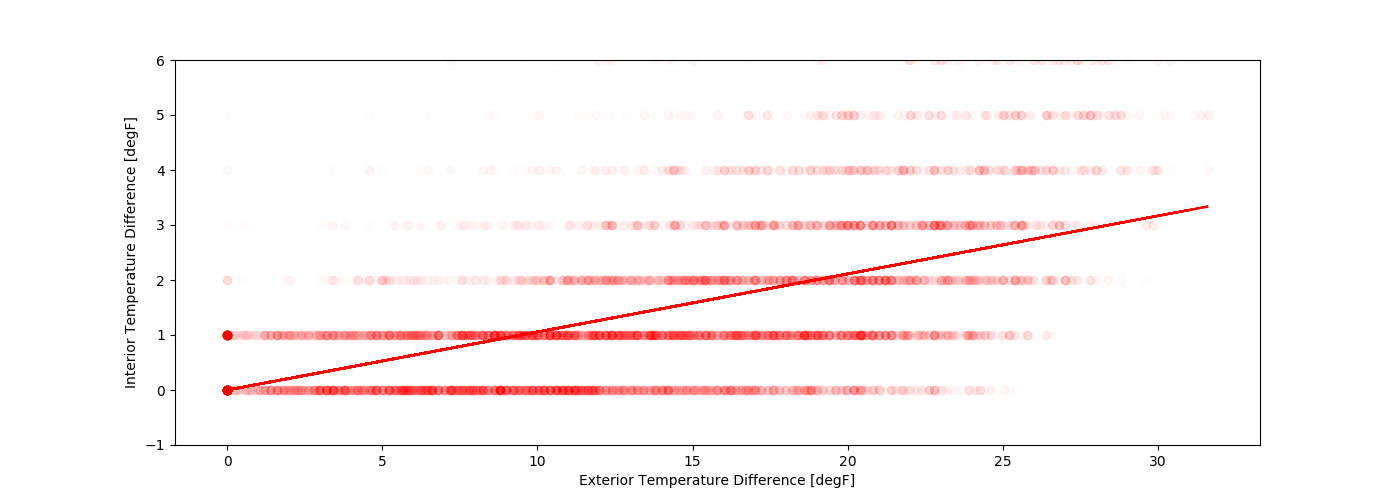

<IPython.core.display.Javascript object>


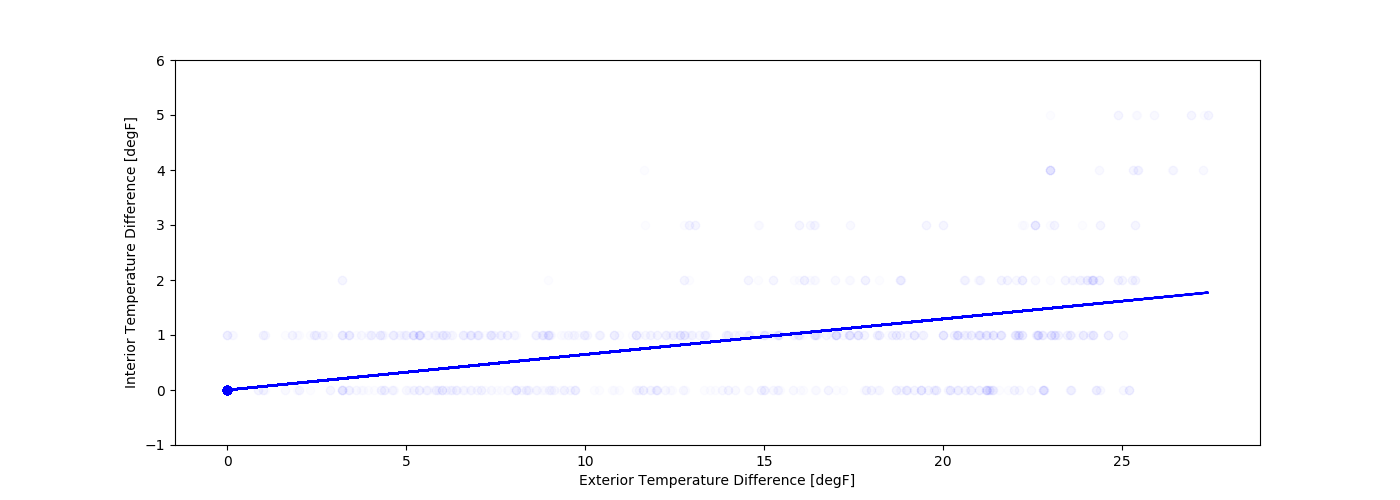

In [6]:
dfs = [pre_repair, post_repair]
for c, pdf in zip(['r', 'b'], dfs):
    
    plt.figure(figsize=[14,5])

    X = pdf.ext_delta 
    y = pdf.setpoint_delta

    model = sm.OLS(y, X).fit()
    predictions = model.predict(X) # make the predictions by the model

    plt.plot(X, predictions, c=c)

    plt.scatter(pdf.ext_delta, pdf.setpoint_delta, alpha=0.01, c=c)
    
    plt.ylim(-1,6)
    plt.xlabel('Exterior Temperature Difference [degF]')
    plt.ylabel('Interior Temperature Difference [degF]')

<IPython.core.display.Javascript object>


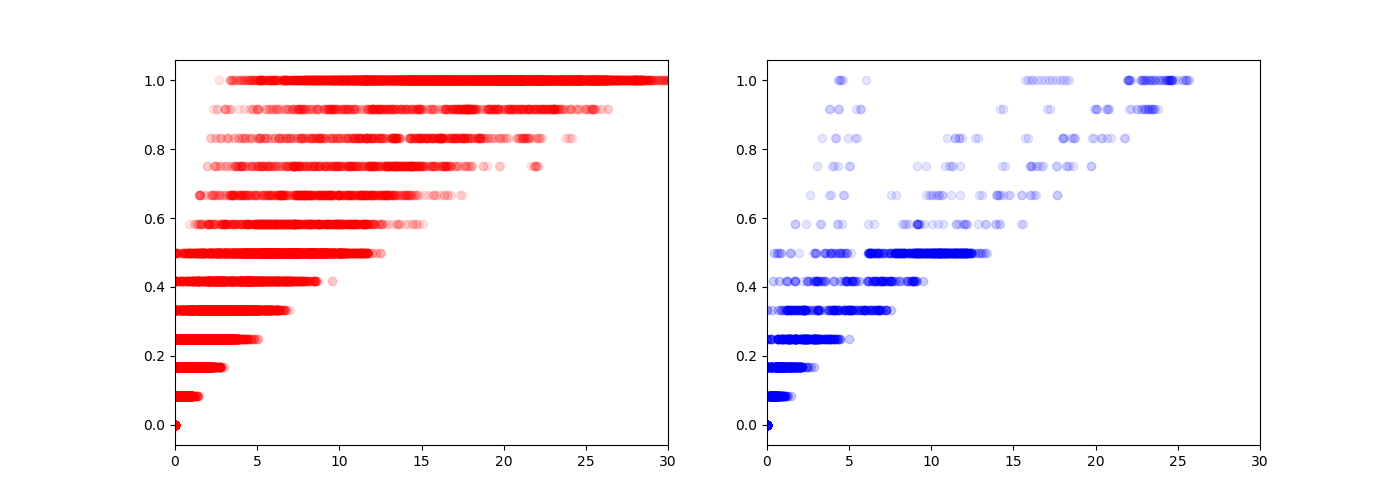

In [7]:
plt.figure(figsize=[14,5])    
n = 1

for c, pdf in zip(['r', 'b'], dfs):
    
    ax = plt.subplot(1, 2, n)
    plt.scatter(pdf.ext_delta.rolling(12).mean(), pdf.cooling.rolling(12).mean(), alpha=0.1, c=c)
    plt.xlim(0,30)
    
    n += 1